# Water Segmentation using Multispectral and Optical Data

This repository contains the implementation of a U-Net model using ResNet50 as the backbone for water body segmentation using multispectral and optical data.

---

## Table of Contents:
1. **Introduction**
2. **Setup and Imports**
3. **Data Loading and Preprocessing**
4. **Model Architecture**
5. **Training**
6. **Results**
7. **Evaluation**
8. **Conclusion**

---

## 1. Introduction
In this project, we perform water segmentation using a deep learning approach. We use a U-Net architecture with ResNet50 as the backbone for feature extraction. The dataset contains multispectral images, and the goal is to segment water bodies from non-water areas.

---

## 2. Setup and Imports


In [19]:

# Required imports and setup for the project
import os
import tensorflow as tf
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model
import tensorflow.image as tfi
import random

## 3. Data Loading and Preprocessing

In [20]:
# Define the directories containing the images and labels
images_dir = '/kaggle/input/water-segmentation/data-20240905T161139Z-001/data/images'
labels_dir = '/kaggle/input/water-segmentation/data-20240905T161139Z-001/data/labels'

# Function to load and preprocess data
def load_data(images_dir, labels_dir):
    images = []
    labels = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith('.tif'):
            image_path = os.path.join(images_dir, filename)
            image = tiff.imread(image_path)
        
            label_path = os.path.join(labels_dir, filename.replace('.tif', '.png'))
            if os.path.exists(label_path):
                label = Image.open(label_path)
                label = np.array(label)
                images.append(image)   # Append the image to the images list
                labels.append(label)   # Append the label to the labels list
            else:
                print(f"Label for {filename} is not found.")
    
    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data(images_dir, labels_dir)


## 4. Splitting the Data into Train, Validation, and Test Sets

In [21]:
# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


## 5. Prepare TensorFlow Datasets

In [22]:
# Create TensorFlow datasets and batch the data
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


## 6. Model Architecture

In [23]:
# Define the U-Net model architecture with ResNet50 as backbone
def unet_model(input_size=(128, 128, 12)):
    # Input Layer
    inputs = layers.Input(input_size)

    # Custom Convolution Block before feeding to ResNet50
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer=he_normal(), name='custom_conv1_conv')(inputs)
    x = layers.BatchNormalization(axis=-1, name='custom_conv1_bn')(x)
    x = layers.Activation('relu', name='custom_conv1_relu')(x)

    # Load pre-trained ResNet50 without the fully connected top layer
    resnet50 = ResNet50(include_top=False, weights=None, input_tensor=x)

    # Extract feature maps from ResNet50 for the skip connections
    c1 = resnet50.get_layer('conv1_relu').output   # 64x64x64
    c2 = resnet50.get_layer('conv2_block3_out').output   # 32x32x256
    c3 = resnet50.get_layer('conv3_block4_out').output   # 16x16x512
    c4 = resnet50.get_layer('conv4_block6_out').output   # 8x8x1024
    c5 = resnet50.get_layer('conv5_block3_out').output   # 4x4x2048

    # Decoder starts here
    u6 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    
    u10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u10)
    c10 = layers.BatchNormalization()(c10)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c10)
    c10 = layers.BatchNormalization()(c10)
    
    u11 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    c11 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u11)
    c11 = layers.BatchNormalization()(c11)
    c11 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c11)
    c11 = layers.BatchNormalization()(c11)

    # Final Output Layer (1 channel - water vs non-water segmentation)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

    # Compile the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()

# Summary of the model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_conv1_conv   │ (None, 64, 64,    │     37,696 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_conv1_bn     │ (None, 64, 64,    │        256 │ custom_conv1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_conv1_relu   │ (None, 64, 64,    │          0 │ custom_conv1_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70,    │          0 │ custom_conv1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │    200,768 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]

 Total params: 72,640,961 (277.10 MB)

 Trainable params: 72,579,649 (276.87 MB)

 Non-trainable params: 61,312 (239.50 KB)

## 7. Training the Model

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Define learning rate scheduler and compile the model
initial_learning_rate = 1e-4
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    callbacks=[lr_scheduler])


Epoch 1/50


I0000 00:00:1726556142.439568      87 service.cc:145] XLA service 0x7811b8001410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726556142.439627      87 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726556142.439631      87 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726556191.700858      87 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_45', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1726556191.751815      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 144s 9s/step - accuracy: 0.5360 - loss: 0.8405 - val_accuracy: 0.4222 - val_loss: 0.6998 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.6787 - loss: 0.6269 - val_accuracy: 0.6180 - val_loss: 0.6846 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8142 - loss: 0.4880 - val_accuracy: 0.7087 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.8655 - loss: 0.4136 - val_accuracy: 0.7856 - val_loss: 0.6402 - learning_rate: 1.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.8800 - loss: 0.3701 - val_accuracy: 0.8196 - val_loss: 0.6153 - learning_rate: 1.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.8925 - loss: 0.3353 - val_accuracy: 0.8304 - val_loss: 0.5953 - learning_rate: 1.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.9046 - loss: 0.3022 - va

## 8. Plot Training and Validation Loss

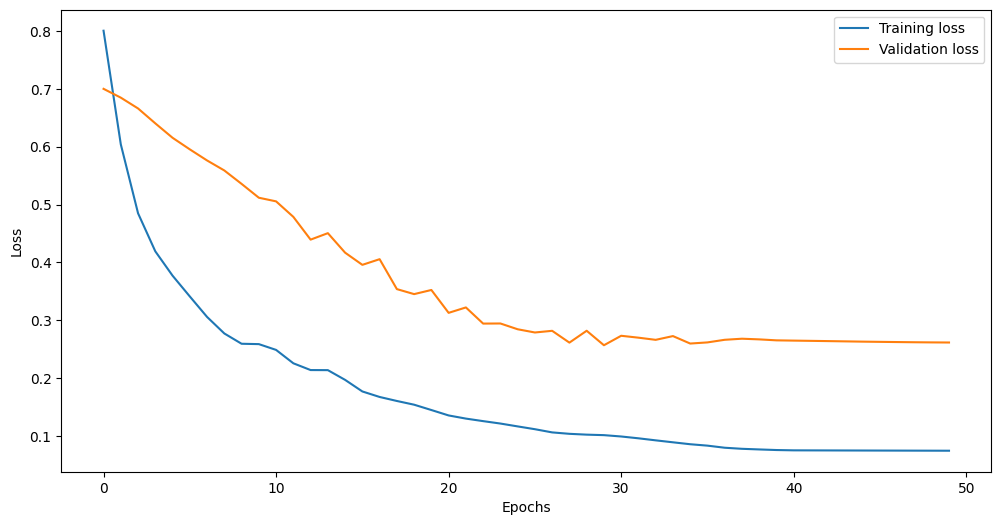

In [25]:
# Plot the training and validation loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 9. Plot Training and Validation Accuracy

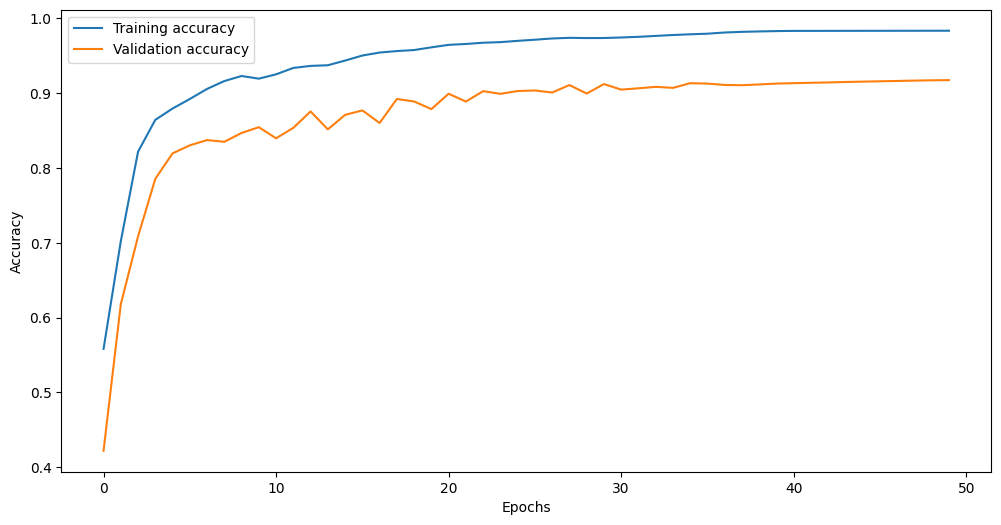

In [26]:
# Plot the training and validation accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 10. Evaluation on Test Set


In [27]:
# Evaluate the model on the test dataset
model.evaluate(test_dataset)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8873 - loss: 0.3312


[0.3364180624485016, 0.8856798410415649]

## 11 Saving the Model

In [28]:
# Save the model to a file
model.save("unet_water_segmentation_model.h5")


## 12. Make Predictions and Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


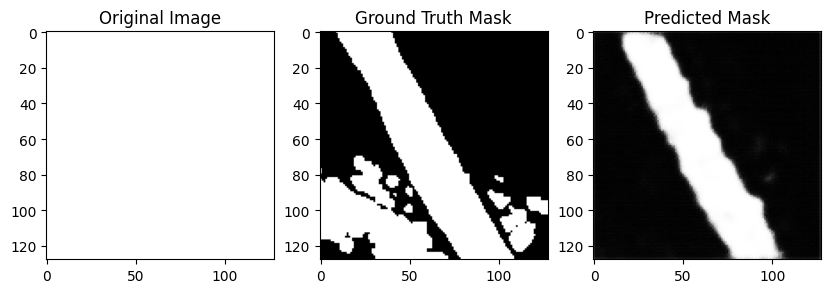

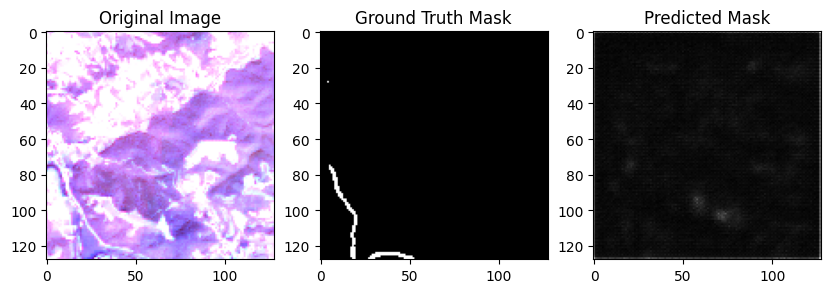

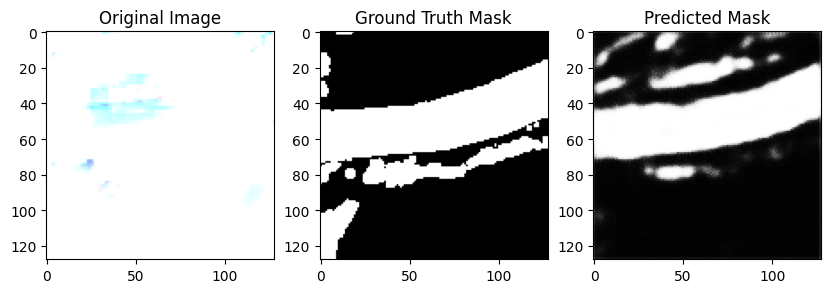

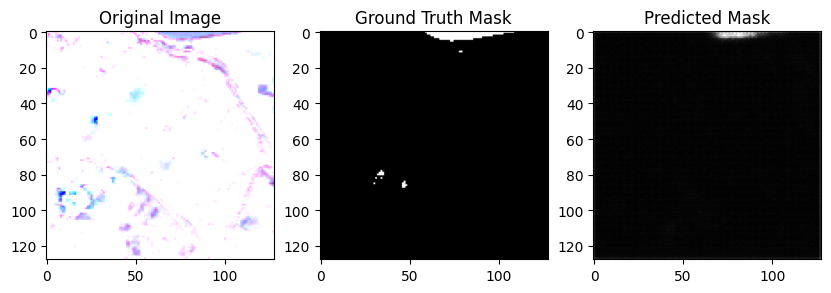

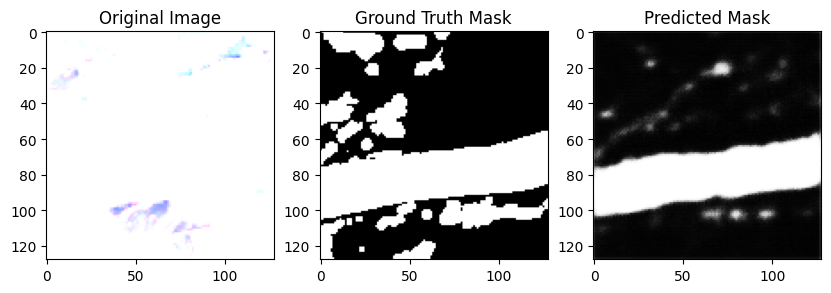

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


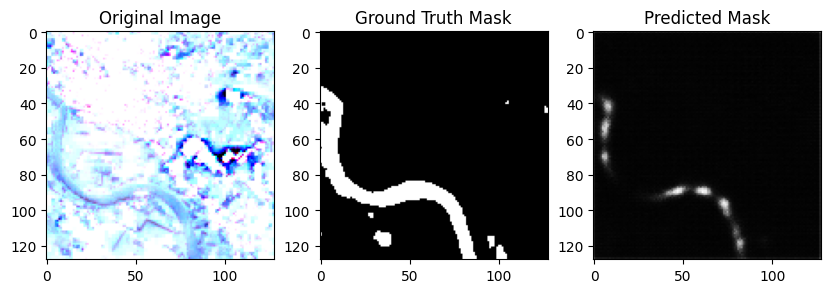

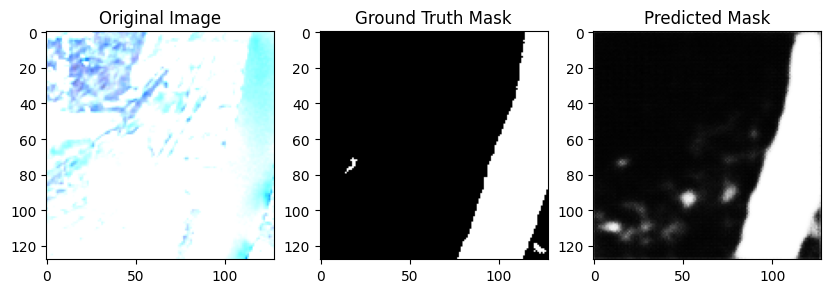

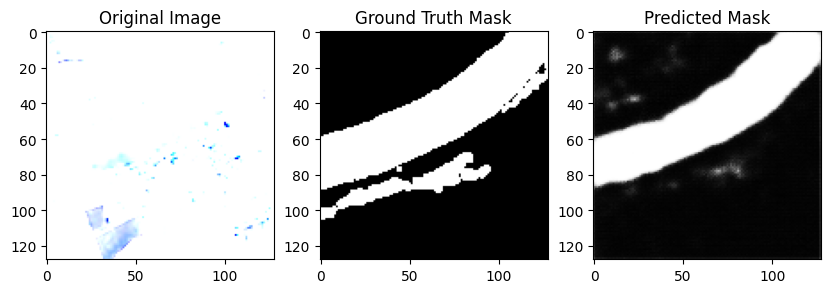

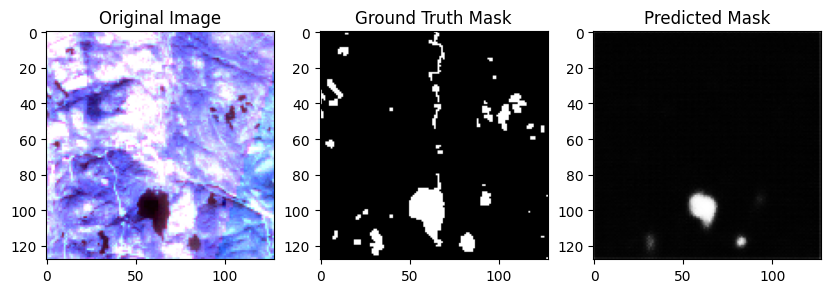

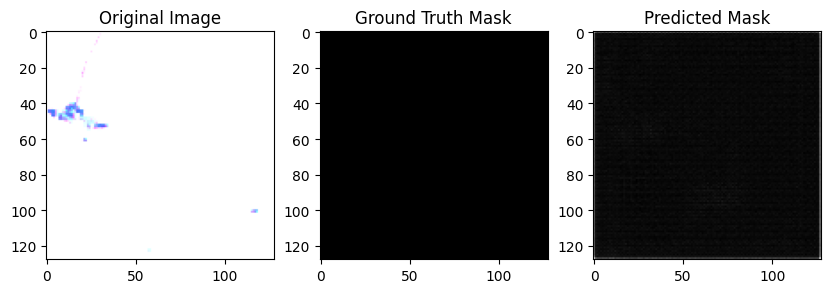

In [29]:
# Visualize some test predictions
def display_predictions(test_dataset, model, num=3):
    for images, masks in test_dataset.take(num):
        preds = model.predict(images)
        for i in range(min(len(images), num)):
            plt.figure(figsize=(10,10))
            # Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(images[i].numpy()[:, :, :3])  # Displaying RGB bands
            plt.title("Original Image")

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].numpy(), cmap='gray')
            plt.title("Ground Truth Mask")

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i], cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

# Call the function to display predictions
display_predictions(test_dataset, model, num=5)


## 13. Model Evaluation

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = model.predict(X_test)

# Calculate F1 Score, Precision, and Recall
y_pred_flat = (y_pred.flatten() > 0.5).astype(int)
y_true_flat = Y_test.flatten()

f1 = f1_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
F1 Score: 0.7569213060271013
Precision: 0.9710660045460469
Recall: 0.6201602352212365
